# Visualize LinkedIn Network with Python
Name: Yaqi Gong, Bing Li

On LinkedIn, we can only see our contact list, and it is difficult to visualize our entire network of contacts. Next, let's try to visualize our LinkedIn contact network and see what our connections look like.
And in the Network we created, where the number of companies corresponds to the size of the node. For example, if you connect with a large number of people who work at SAP, the SAP node will be large.

## 1. Download dataset.
Here’s a step for getting a copy of your data on LinkedIn:

In the homepage, click on “Me”-“Settings & Privacy”- “Data Privacy”-“Get a copy of your data”-click "Connections"


In [1]:
import pandas as pd  #python data analysis library
import janitor #a python tool for data cleaning
import datetime # The datetime module provides classes for manipulating dates and times.

from IPython.core.display import display, HTML
from pyvis import network as net #Visualizing network graph
import networkx as nx 



/var/folders/x8/xq3t69xx1pj8c92rpv1tyfk40000gn/T/ipykernel_22284/581041841.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## 2. Load data

In [2]:
#skiprows = 2 means read starting from line3, since we don't need the first 2 rows
df_ori = pd.read_csv("/Users/gongyaqi/Downloads/Connections.csv", skiprows=2)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     153 non-null    object
 1   Last Name      153 non-null    object
 2   Email Address  4 non-null      object
 3   Company        139 non-null    object
 4   Position       139 non-null    object
 5   Connected On   155 non-null    object
dtypes: object(6)
memory usage: 7.4+ KB


Use "df_ori.info()" to print the information of the data, there is 155 conections in total.

## 3.  Data cleaning
 Do the data cleaning with janitor library.  
In order to generate the network, we must organize the data into a unified form. In this way, the data will become easier to process, and we can more accurately calculate the number of Connections for each company or position. So  what we basically do are: cleaning the column names, dropping columns, removing missing values, and converting the date column to DateTime format.

In [3]:
df = (
    df_ori
    .clean_names() # remove spacing and capitalization from column names
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy,
    # It removes these columns for privacy reasons or because they are not required 
    #for further analysis.
    .dropna(subset=['company', 'position']) # drop missing values in company 
    #and position
    #This code drops rows from the DataFrame where either the 'company' or 
    #'position' columns have missing values (NaN).
    # It ensures that the remaining data has values for these important columns.
    .to_datetime('connected_on', format='%d %b %Y')
    #This line converts the 'connected_on' column to a datetime format
  )
df.head()

,company,position,connected_on
0,NEC Laboratories Europe GmbH,Research Theme Coordinator,2023-05-03
1,"Shanghai Teneb International Co., Ltd",Head of Sales and Business Development,2023-05-03
2,Integration International Inc.,Technical Consultant,2023-05-03
3,Claimer,Software Consultant (R&D Tax Credit),2023-05-02
4,Clarusway,AWS Cloud Solutions Architect and Devops Engineer,2023-04-27


## 4. Simple visulization using pandas

We show the top 10 companies with the most connections. Very intuitive and clear at a glance.

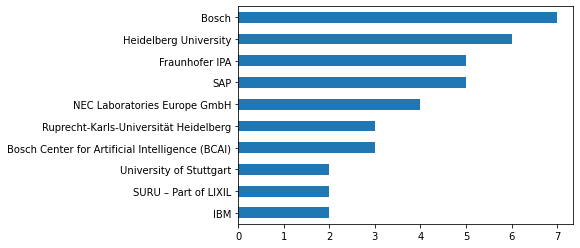

In [4]:
df['company'].value_counts().head(10).plot(kind="barh").invert_yaxis();

Similarly, we show the top 10 positions with the most connections

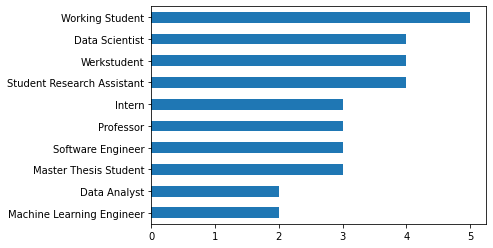

In [5]:
df['position'].value_counts().head(10).plot(kind="barh").invert_yaxis();

‘xrot=35’ This parameter rotates the x-axis labels by 30 degrees. It can be useful when the x-axis labels are long and overlapping, making them difficult to read.

Plotting the date of the connections. It seems that, 2022-3 to 2022-04 and 2023-1 to 2023-2, there are most connections.Maybe a job finding period is going through.

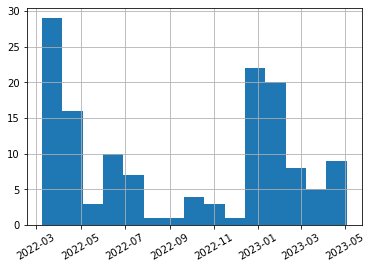

In [6]:
df['connected_on'].hist(xrot=30, bins=15);
# bins = 15,this parameter specifies the number 
#of intervals to use for the histogram

## 5. Aggregate position and connection columns

We count the number of connections I have with each of these companies separately

In [7]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,Bosch,7
1,Heidelberg University,6
2,Fraunhofer IPA,5
3,SAP,5
4,NEC Laboratories Europe GmbH,4
5,Ruprecht-Karls-Universität Heidelberg,3
6,Bosch Center for Artificial Intelligence (BCAI),3
7,University of Stuttgart,2
8,SURU – Part of LIXIL,2
9,IBM,2


In [8]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Working Student,5
2,Werkstudent,4
3,Student Research Assistant,4
1,Data Scientist,4
4,Intern,3
5,Professor,3
6,Software Engineer,3
7,Master Thesis Student,3
10,Business Analyst,2
11,Research Assistant,2


## 6. Creating the network
For creating the network, we use PyVis and networkX.

In [15]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=2]
print(df_company_reduced.shape)

(109, 2)
(11, 2)


In [9]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=2]
print(df_position_reduced.shape)

(114, 2)
(12, 2)


In [19]:
# initialize graph
g = nx.Graph()  #Initialized a graph object using the NetworkX library
g.add_node('Me') #Adds a node with the label 'Me' to the graph. 
#This represents myself as the central node.

# enters a loop that iterates through each row in the df_company DataFrame.
# row represents the current row being iterated.
for _, row in df_company.iterrows():

  #extracts the value of the 'company' column from the current row and
  #assigns it to the variable company.
  company = row['company']

  # extracts the value of the 'count' column from the current row and
  # assigns it to the variable count.
  count = row['count']
    
  # creates a string variable title that contains the 
  # HTML-formatted company name (bold) followed by a hyphen and the count value.
  title = f"<b>{company}</b> – {count}"

  #This line filters the DataFrame df to select rows where the 'company' column matches 
  #the current company. It then extracts the values from the 'position' column 
  #for those rows and creates a set of unique positions.
  #The positions are stored in the variable positions.
  positions = set([x for x in df[company == df['company']]['position']])
    
  # creates an HTML-formatted string positions by joining each
#position in the positions set 
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)
    
  # creates an HTML-formatted string position_list by wrapping the positions string
  # with an unordered list tag 
  position_list = f"<ul>{positions}</ul>"
    
  # concatenates the title and position_list strings to create a string hover_info that 
  # contains the company title and the list of positions.
  hover_info = title + position_list
    
  #This line adds a new node to the graph with the label company. 
  #The node is assigned a size based on the count value multiplied by 10. 
  #It also includes a title attribute with the hover_info string and a color 
#attribute set to '#3449eb'.
  g.add_node(company, size=count*10, title=hover_info, color='green')
    
  # This line adds an edge between the 'Me' node and the current company node. 
  # The edge is assigned a color of 'white'.    
  g.add_edge('Me', company, color='black')

# generate the graph
# initializes a Network object nt for visualization using the net.Network class.
nt = net.Network(notebook=True,height='900px', width='900px', bgcolor="white", 
                 font_color='blue',cdn_resources='remote')

# converts the NetworkX graph g into a format that can be visualized by the Network 
#object nt.
nt.from_nx(g)

#applies the H-Repulsion layout algorithm to the graph to arrange the nodes in a 
#visually pleasing manner.
nt.hrepulsion()

nt.show('company_graph.html')
#display(HTML('company_graph.html'))

company_graph.html


We generate a new data set named "df_company_reduced", in which there are only entries with a connection number greater than 2.In this way, the network won't be too complex.

In [20]:

g = nx.Graph()
g.add_node('Me') 


for _, row in df_company_reduced.iterrows():

 
  company = row['company']
  count = row['count']


  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*10, title=hover_info, color='green')
  g.add_edge('Me', company, color='black')


nt = net.Network(notebook=True,height='900px', width='900px', bgcolor="white", font_color='blue',cdn_resources='remote')
nt.from_nx(g)
nt.hrepulsion()

nt.show('company_graph_reduced.html')
#display(HTML('company_graph_reduced.html'))

company_graph_reduced.html


We generate the network of positions

In [21]:

g = nx.Graph()
g.add_node('Me') 


for _, row in df_position.iterrows():


  position = row['position']
  count = row['count']


  title = f"<b>{position}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(position, size=count*10, title=hover_info, color='green')
  g.add_edge('Me', position, color='black')


nt = net.Network(notebook=True,height='900px', width='900px', bgcolor="white", font_color='blue',cdn_resources='remote')
nt.from_nx(g)
nt.hrepulsion()

nt.show('position_graph.html')
#display(HTML('position_graph.html'))

position_graph.html


Similarly, we generate a new data set named "df_position_reduced", in which there are only entries with a connection number greater than 2.In this way, the network won't be too complex.

In [22]:

g = nx.Graph()
g.add_node('Me') 


for _, row in df_position_reduced.iterrows():


  position = row['position']
  count = row['count']


  title = f"<b>{position}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(position, size=count*10, title=hover_info, color='green')
  g.add_edge('Me', position, color='black')


nt = net.Network(notebook=True,height='900px', width='900px', bgcolor="white", font_color='blue',cdn_resources='remote')
nt.from_nx(g)
nt.hrepulsion()

nt.show('position_graph_reduced.html')
#display(HTML('position_graph_reduced.html'))

position_graph_reduced.html


References: 
1. https://medium.com/bitgrit-data-science-publication/visualize-your-linkedin-network-with-python-59a213786c4
2. https://pandas.pydata.org/
3. https://pyvis.readthedocs.io/en/latest/tutorial.html
4. https://networkx.org/
5. https://socnetv.org/
